In [145]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Danych

In [146]:
import json
from pathlib import Path, PurePath
from speed_analyse_scripts.utils import get_latest_file_from_directory
from stitch.rectify.FrameRectifier import FrameRectifier

file_extension = "avi"
# file_extension = "csv"
dir_paths = [
    "resources/speeds/same_wagony/",
    # "resources/speeds/full_train/",
    # "resources/speeds/full_train_speed_up/",
]

rectify_config = "resources/best.json"
with open(rectify_config) as f:
    rectify_config = json.load(f)

frame_size = (1920, 1080)
frame_rectifier = FrameRectifier(rectify_config, *frame_size)
frame_rectifier.calc_maps()

files_paths = [get_latest_file_from_directory(dir_path, file_extension) for dir_path in dir_paths]
files_paths = [PurePath(file_path) for file_path in files_paths]

files = {}
for file_path in files_paths:
    parent_dir_name = file_path.parent.name
    files[parent_dir_name] = str(file_path)
    # files[parent_dir_name] = pd.read_csv(file_path)

files


{'same_wagony': 'resources\\speeds\\same_wagony\\same_wagony.avi'}

In [147]:

import copy
from speed_analyse_scripts.utils import Measurement
from stitch.speed.VelocityEstimator import VelocityEstimator
from stitch.speed.regression.LstsqMethod import LstsqMethod
from stitch.speed.regression.MeanMethod import MeanMethod
from stitch.speed.regression.MedianMethod import MedianMethod
from stitch.speed.regression.OlsMethod import OlsMethod
from stitch.speed.regression.WlsMethod import WlsMethod

velocity_estimators = {
    "lstsq": VelocityEstimator(LstsqMethod(), LstsqMethod()),
    # "OLS": VelocityEstimator(OlsMethod(), OlsMethod()),
    # "WLS": VelocityEstimator(WlsMethod(), WlsMethod()),
    "Mean": VelocityEstimator(MeanMethod(10), MeanMethod(2), center=False),
    "Median": VelocityEstimator(MedianMethod(10), MedianMethod(2), center=False),
}

raw_velocities = {key: [] for key, value in files.items()}

measurements = []
for file_name in files.keys(): 
    for method_name, estimator in velocity_estimators.items():
        velocity_estimator = copy.deepcopy(estimator)

        measurement = Measurement(file_name, method_name, velocity_estimator, [])
        measurements.append(measurement)

print(raw_velocities)
measurements


{'same_wagony': []}


[Measurement(dataset_name='same_wagony', method_name='lstsq', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x0000022009DF9520>, results=[]),
 Measurement(dataset_name='same_wagony', method_name='WLS', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x0000022009DF2FD0>, results=[])]

# Testy metod na zbiorach

In [148]:
import cv2
from tqdm import tqdm

def measure_velocity_from_movie(movie_path, dataset_name, frame_rectifier, *measurements, max_frames=-1):
    input_cam = cv2.VideoCapture(movie_path)
    total_frames = input_cam.get(cv2.CAP_PROP_FRAME_COUNT)

    counter = 0
    with tqdm(total=total_frames, desc=dataset_name) as pbar:
        while input_cam.isOpened():
            ret, frame = input_cam.read()

            if ret:
                frame = frame_rectifier.rectify(frame)
                append_raw_velocity = True

                for measurement in measurements:
                    velocity = measurement.velocity_estimator.get_velocity(frame)
                    result = (counter, velocity[0], velocity[1])
                    measurement.results.append(result)

                    if append_raw_velocity:
                        measurement = measurements[0]
                        raw_velocity = measurement.velocity_estimator.old_raw_velocity
                        raw_velocities[dataset_name].append(raw_velocity)
                        append_raw_velocity = False
            else:
                break


            counter += 1
            pbar.update(1)
            
            if max_frames > 0 and counter > max_frames:
                break

    input_cam.release()

In [149]:
for dataset_name, file_path in files.items():
    frame_size = (1920, 1080)
    frame_rectifier = FrameRectifier(rectify_config, *frame_size)
    frame_rectifier.calc_maps()

    selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
    selected_measurements = list(selected_measurements)

    max_frames = 500
    measure_velocity_from_movie(file_path, dataset_name, frame_rectifier, max_frames=max_frames, *selected_measurements)    
    

same_wagony: 100%|██████████| 308/308.0 [00:52<00:00,  5.90it/s]


In [150]:
from functools import reduce
from speed_analyse_scripts.utils import filter_error

filtered = {}
for key, value in raw_velocities.items():
    if len(value) != 0:
        concatenated_array = reduce(lambda a, b: np.append(a, b, axis=0), value)
        raw_velocities[key] = concatenated_array

        df = pd.DataFrame(concatenated_array)
        headers = ["frame", "x", "y"]
        df.columns = headers
        filtered[key] = filter_error(df).to_numpy()
        

In [151]:
raw_velocities

{'same_wagony': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  5.00488281e-03,  7.56835938e-03],
        [ 1.00000000e+00,  7.32421875e-04, -1.22070312e-04],
        ...,
        [ 3.07000000e+02,  0.00000000e+00,  0.00000000e+00],
        [ 3.07000000e+02, -2.38054657e+01, -3.17623138e-01],
        [ 3.07000000e+02, -2.60095215e+01,  7.85537720e-01]])}

# Porównanie metod regresji

c:\Users\wrzezniczak\Desktop\onyks_owl\poc\speed_analyse_scripts\ComposedPlot.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


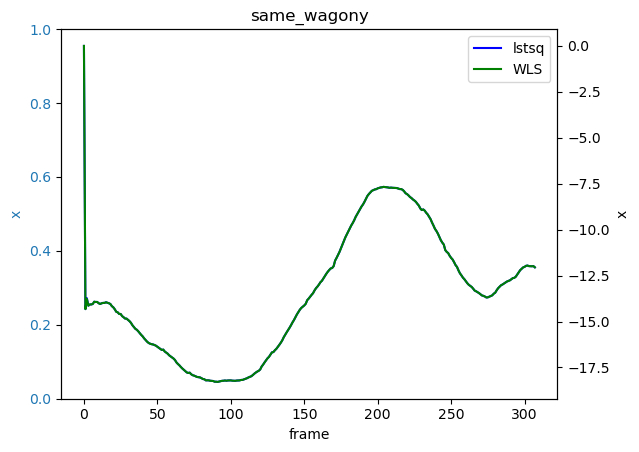

In [152]:
from speed_analyse_scripts.ComposedPlot import ComposedPlot


def ax1_call(axe):
    color = "tab:blue"
    axe.set_xlabel("frame")
    axe.set_ylabel("x", color=color)
    axe.tick_params(axis='y', labelcolor=color)

def ax2_call(axe):
    axe.set_ylabel("x")

for dataset_name in files.keys():
    ax_callbacks = [ax1_call, ax2_call]
    Composed_x = ComposedPlot(dataset_name, *ax_callbacks)	

    colors = ["blue", "green", "orange", "purple"]

    # original = raw_velocities[dataset_name] 
    # x = original[:, 0]
    # y = original[:, 1]
    # Composed_x.add_plot(0, x, y, color="grey", label="original x")

    # _filtered = filtered[dataset_name] 
    # x = _filtered[:, 0]
    # y = _filtered[:, 1]
    # Composed_x.add_plot(1, x, y, color="grey", label="filtered x")
    
    selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
    selected_measurements = list(selected_measurements)
    for measurement, color in zip(selected_measurements, colors):
        array = np.array(measurement.results)
        x = array[:, 0]
        y = array[:, 1]
        Composed_x.add_plot(1, x, y, color=color, label=measurement.method_name)
    Composed_x.show_composed()

In [153]:
# import random

# def raw_velocity_generator(frames_number: int, measurements_in_frame: tuple[int, int],
#                             data_range: tuple[int, int]) -> object:
#     for frame_number in range(1, frames_number):
#         measurements_number = random.choice(list(range(*measurements_in_frame)))
#         shape = (measurements_number, 1)

#         frame = np.tile([frame_number], shape)

#         min_val, max_val = data_range
#         x = np.random.uniform(min_val, max_val, shape)
#         y = np.random.uniform(min_val, max_val, shape)

#         yield np.hstack([frame, x, y])

# def remove_random_frames(raw_velocity, number_to_remove):
#     frames_numbers = np.unique(raw_velocity[:, 0])
#     indexes_to_remove = random.sample(list(frames_numbers), number_to_remove)

#     conditions = []
#     for i in indexes_to_remove:
#         conditions.append(raw_velocity[:, 0] != i)

#     mask = np.logical_and.reduce(np.array(conditions))
#     return raw_velocity[mask]



In [154]:
# from unittest.mock import patch
# from stitch.speed.regression.MeanMethod import MeanMethod


# mean_estimator = VelocityEstimator(MeanMethod(), MeanMethod())
# estimators = [mean_estimator]

# @patch()
# def test_estimator(estimator, frame, counter):
#     velocity = estimator.get_velocity(frame)
#     result = (counter, velocity[0], velocity[1])
#     print(result)

# for counter, frame in enumerate(raw_velocity_generator(10, (0, 10), (-100, 100))):
#     for estimator in estimators:
#        test_estimator(estimator, frame, counter)     